In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pyslaw.steadystate import HalfPlaneModel

# Analytical solution of the flow over the Witch of Agnesi hill

This notebook shows how to calculate the semi-analytical solution of the uniform, stratified flow over a bell-shaped hill (also known as the With of Agnesi). The semi-analytical solution is obtained with PySLAW, which solves linear theory of atmospheric gravity waves.

Created by Dries Allaerts

## Set-up

### Input parameters

Flow parameters: wind speed U and Brunt Vaisala frequency N

In [8]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape $h\left(x\right) = \large\frac{h_{max}}{1+\left(\frac{x}{L}\right)^2}$


In [9]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 100.0 # Height of the hill [m]

# Shape function of the hill
h = lambda x: hmax/(1+(x/L)**2)

Numerical parameters

In [10]:
Lx = 2000.0e3 # Length of the numerical domain [m]
Nx = int(1e5) # Number of grid points

Parameters for visualization

In [11]:
Lz = 15.0e3 # Height up to which solution is calculated [m]
Nz = 151    # Number of vertical levels to be used

### Numerical grid

In [12]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 2000.0 m


In [13]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 100.0 m


### Model

In [14]:
model = HalfPlaneModel(xs,h(xs),U,N)

### Visualize hill

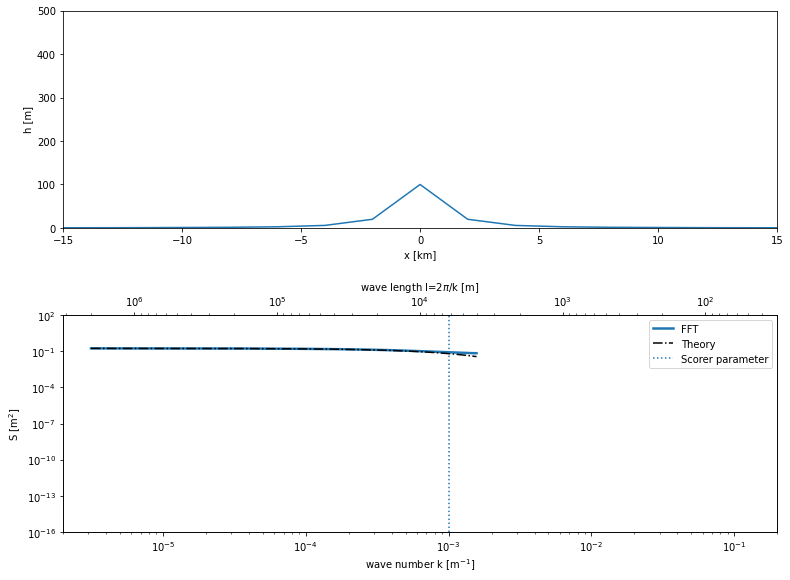

In [15]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(xs/1.e3,h(xs))
ax[1].loglog(model.k[1:],np.abs(model.hc[1:]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-15,15],ylim=[0,500],xlabel='x [km]',ylabel='h [m]')
_ = ax[1].set(xlim=[2e-6,2e-1],ylim=[1e-16,1e2],xlabel=r'wave number k [m$^{-1}$]',ylabel=r'S [m$^2$]')

# Theoretical Fourier transform pair
# In theory, scale factor = pi * L * hmax. However, due to the discrete nature, the scale factor for the
# fft is the integral of h(xs), which approximates pi * L * hmax. As in pyslaw the fft is scaled with Nx
# such that the first mode corresponds to the mean value rather than the sum, the scale is set as
# the mean rather than the integral
scale = np.mean(h(xs))
ax[1].loglog(model.k[1:],scale*np.exp(-L*model.k[1:]),'-.k',label='Theory')
ax[1].axvline(N/U,linestyle=':',label='Scorer parameter')
ax[1].legend()
ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'wave length l=2$\pi$/k [m]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

Note in the lower plot that for $k>0.03$, the FFT deviates from the theoretical Fourier transform of a bell-shaped curve, which is likely due to round-off errors. Therefore, for the current set of input parameters, a grid resolution of 100m (corresponding to a maximum wave length of 200m) would in fact be sufficient.

## Solve flow problem

In [16]:
%time eta = model.solve('eta',zs)

CPU times: user 11.8 ms, sys: 5.96 ms, total: 17.8 ms
Wall time: 26.7 ms


In [17]:
%time w = model.solve('w',zs)

CPU times: user 10.5 ms, sys: 3.09 ms, total: 13.6 ms
Wall time: 19.9 ms


## Visualization

### Contourplots of vertical displacement $\eta$ and vertical velocity $w$

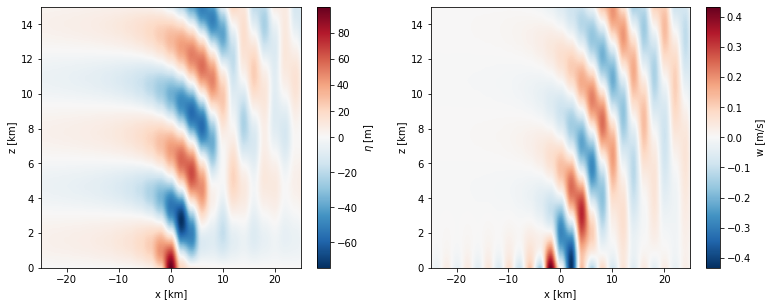

In [18]:
f,ax=plt.subplots(1,2,figsize=(12.8,4.8))

# Plot displacement in left axis
im=ax[0].imshow(eta.T,
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.))
cbar = f.colorbar(im,ax=ax[0],shrink=1.0,label=r'$\eta$ [m]')
_ = ax[0].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]')

# Plot vertical velocity in right axis
im=ax[1].imshow(w.T,
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.))

# figure mark-up
cbar = f.colorbar(im,ax=ax[1],shrink=1.0,label='w [m/s]')
_ = ax[1].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]')

### Contourplot of vertical velocity $w$ overlaid with streamlines

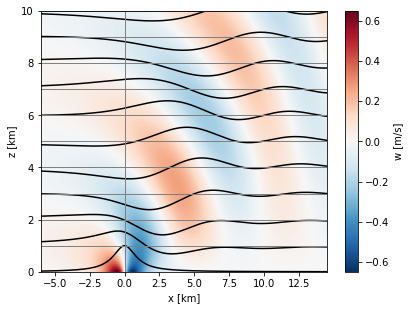

In [14]:
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))

# background image showing vertical velocity contours
im=ax.imshow(w.T,
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.))

# streamlines (vertical displacement scaled by a factor 10 for visibility)
for kz in range(0,Nz,10):
    ax.plot(xs/1e3,10*eta[:,kz]/1e3+zs[kz]/1e3,'k',linewidth=1.5)
    ax.axhline(zs[kz]/1e3,color='gray',linewidth=1)
ax.axvline(0,color='gray',linewidth=1)

# figure mark-up
cbar = f.colorbar(im,ax=ax,shrink=1.0,label='w [m/s]')
_ = ax.set(xlim=[-6,14.5],ylim=[0,10],xlabel='x [km]',ylabel='z [km]')

### Visualization of streamlines

This plot reproduces figure 3.11 from [Nappo (2002)](https://www.elsevier.com/books/an-introduction-to-atmospheric-gravity-waves/nappo/978-0-12-385223-6)

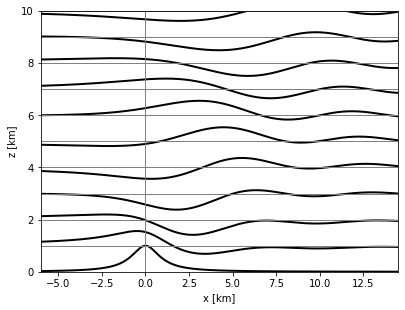

In [15]:
#Displacement is scaled by a factor 10 for visibility
f,ax=plt.subplots(1,1,figsize=(6.4,4.8))
for kz in range(0,Nz,10):
    ax.plot(xs/1e3,10*eta[:,kz]/1e3+zs[kz]/1e3,'k',linewidth=2)
    ax.axhline(zs[kz]/1e3,color='gray',linewidth=1)
ax.axvline(0,color='gray',linewidth=1)
_ = ax.set(xlim=[-6,14.5],ylim=[0,10],xlabel='x [km]',ylabel='z [km]')